# Online Identity as a Collective Labeling Process: Simulation and Plotting Code

## Preliminaries

In [2]:
import os
import sys
import json
import bz2
import pickle
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pyp
import pandas as pd

from collections import Counter
from itertools import chain, zip_longest
from glob import glob

from scipy.optimize import curve_fit

In [3]:
%matplotlib inline

In [4]:
# Matplotlib globals.

mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['font.family'] = 'serif'

In [5]:
# Colors.

magenta = np.array([206,0,142])/256.

## Data

In [6]:
# Load profile updates.

fname = 'OnlineIdent_CollectiveLabelProc_anchorlabel_profileupdates.json.bz2'
with bz2.open(fname, mode='rt', compresslevel=9) as f:
    anchorlabelupdates = json.load(f)
    
# Make hashtag lists in each profile update into sets (json dislikes sets).
anchorlabelupdates = [{'EndOfWeek': p['EndOfWeek'],
                       'UserMarker': p['UserMarker'],
                       'TimeOrder': p['TimeOrder'],
                       'Hashtags': set(p['Hashtags'])} for p in anchorlabelupdates]

In [7]:
anchorlabelupdates[:2]

[{'EndOfWeek': '2017-07-02',
  'UserMarker': 5314,
  'TimeOrder': 0,
  'Hashtags': {'#blacklivesmatter', '#problack', '#retiredtroll', '#zoelife'}},
 {'EndOfWeek': '2017-07-02',
  'UserMarker': 4256,
  'TimeOrder': 1,
  'Hashtags': {'#blacklivesmatter',
   '#geekdown',
   '#killemall',
   '#rekt',
   '#thelsdrealityshow'}}]

In [8]:
# Define anchor labels and make a dictionary of hashtag profile updates
# for each.  Make sure each is sorted by `TimeOrder`.

anchorlabels = ['#resist', '#blacklivesmatter', '#maga', '#music', '#mufc']

d_anchorlabel_updates = {anchorlabel: sorted([update \
                                            for update in anchorlabelupdates \
                                            if anchorlabel in update['Hashtags']],
                                      key=lambda x: x['TimeOrder']) \
                      for anchorlabel in anchorlabels}

In [9]:
d_anchorlabel_updates['#resist'][:2]

[{'EndOfWeek': '2017-07-02',
  'UserMarker': 4939,
  'TimeOrder': 2,
  'Hashtags': {'#resist', '#stillwithher'}},
 {'EndOfWeek': '2017-07-02',
  'UserMarker': 4783,
  'TimeOrder': 6,
  'Hashtags': {'#aclu', '#antitrump', '#resist'}}]

Note that the prime label is *included* in these updates.  They are removed before calculating correlation or other relevant quantities in various cells below.

In [10]:
# Make statistics table for the anchor labels and display.

rows = []
d_anchorlabel_numcolabels = {}
for anchorlabel, updates in d_anchorlabel_updates.items():
    
    num_users = len(set([update['UserMarker'] for update in updates]))
    num_profiles = len(updates)
    
    # Get a list of all co-labels, with the prime label removed.
    _allcolabels = list(chain(*[update['Hashtags'] - set([anchorlabel]) for update in updates]))
    
    num_colabels = len(_allcolabels)
    num_distinctcolabels = len(set(_allcolabels))
    
    d_anchorlabel_numcolabels[anchorlabel] = num_colabels
    
    rows.append((anchorlabel, num_users, num_profiles, num_colabels, num_distinctcolabels))
    

anchor_df = pd.DataFrame(rows)
anchor_df.columns = ['Anchor label',
                     'Number individuals',
                     'Number profile changes',
                     'Number co-labels',
                     'Number distinct co-labels']
anchor_df.set_index('Anchor label', inplace=True)

anchor_df

,Number individuals,Number profile changes,Number co-labels,Number distinct co-labels
Anchor label,,,,
#resist,1432,4595,17596,3421
#blacklivesmatter,1206,2202,5599,2108
#maga,1184,4519,21398,3000
#music,1027,2318,14949,3978
#mufc,986,1795,5151,2136


In [12]:
def hash_cooccurrences(hashtagprofiles, seed):

    c_dict = {}
    for hts in hashtagprofiles:
        if seed in hts:
            for ht in hts:
                if ht == seed:
                    continue
                if ht in c_dict:
                    c_dict[ht] += 1
                else:
                    c_dict[ht] = 1
                    
    return c_dict

In [13]:
# Get coocurrences for all hashtags.

d_hashtag_cooc = {}
hashtagupdates = [update['Hashtags'] for update in anchorlabelupdates]
for hashtag in set(chain(*hashtagupdates)):

    cooc = hash_cooccurrences(hashtagupdates, hashtag)
    d_hashtag_cooc[hashtag] = cooc

#fbr
#theresistance
#blm
#lgbtq
#impeachtrump
#bluewave
#climatechange


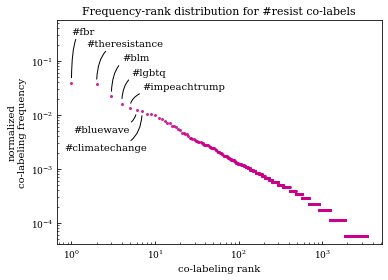

In [14]:
# Plot freq-rank for particular anchor label.

fig, axs = pyp.subplots(figsize=(5.5, 4), ncols=1, nrows=1, sharex=True, sharey=True)
axs = [axs]

_plot_primetags = ['#resist']

for primetag, ax in zip(_plot_primetags, axs):

    primeht_cooc = d_hashtag_cooc[primetag]
    rank, count = zip(*enumerate(sorted(primeht_cooc.values(), reverse=True)))
    rank = np.array(rank)+1
    probs = np.array(count)/sum(count)

    ax.loglog(rank, probs, '.', color=magenta,
              alpha=0.8,
              label='data',
              markersize=4,
              rasterized=False)

    ax.set_ylim(ax.get_ylim()[0], 0.19)

    labelcnt = 8
    top_cotags = [x[0] for x in sorted(primeht_cooc.items(),
                                       key=lambda x: x[1],
                                       reverse=True)][:labelcnt]
    labdiffs = [0.31, 0.17, 0.09, 0.045, 0.02, -0.007, -0.0095]
    xyxs = [1, 1.5, 4, 5.2, 7., 5, 8]
    for top_cotag, rk, prob, labdiff, xyx in zip(top_cotags, rank, probs, labdiffs, xyxs):
        """ax.annotate(top_cotag, xy=(rk, prob),
                    xytext=(0.03*rk + 0.02, 0.6 - 0.03*rk), textcoords='axes fraction',
                    arrowprops={'arrowstyle': '-',
                                'shrinkA': 5,
                                'shrinkB': 5})"""
        print(top_cotag)
        if top_cotag in ['#bluewave', '#climatechange']:
            ha = 'right'
            va = 'center'
        else:
            ha = 'left'
            va = 'center'
        ax.annotate(top_cotag, xy=(rk, prob),
                    xytext=(xyx, prob+labdiff),
                    arrowprops={'arrowstyle': '-',
                                'shrinkA': 1.5,
                                'shrinkB': 5,
                                'connectionstyle': "angle3,angleA=0,angleB=-90"},
                    ha=ha, va=va)

    ax.set_title('Frequency-rank distribution for {} co-labels'.format(primetag))
    
    ax.set_ylim(ax.get_ylim()[0], 0.56)
    

axs[-1].set_xlabel('co-labeling rank')
for ax in axs:
    ax.set_ylabel('normalized\nco-labeling frequency')

fig.tight_layout()

#fbr
#theresistance
#blm
#lgbtq
#impeachtrump
#bluewave
#climatechange
#resist
#freepalestine
#metoo
#defenddaca
#humanrights
#abolishice
#apaop
#2a
#kag
#nra
#trump
#prolife
#americafirst
#military
#art
#travel
#tech
#movies
#books
#photography
#sports
#ggmu
#wwe
#music
#art
#glazersout
#mufc_family
#cherprangbnk48


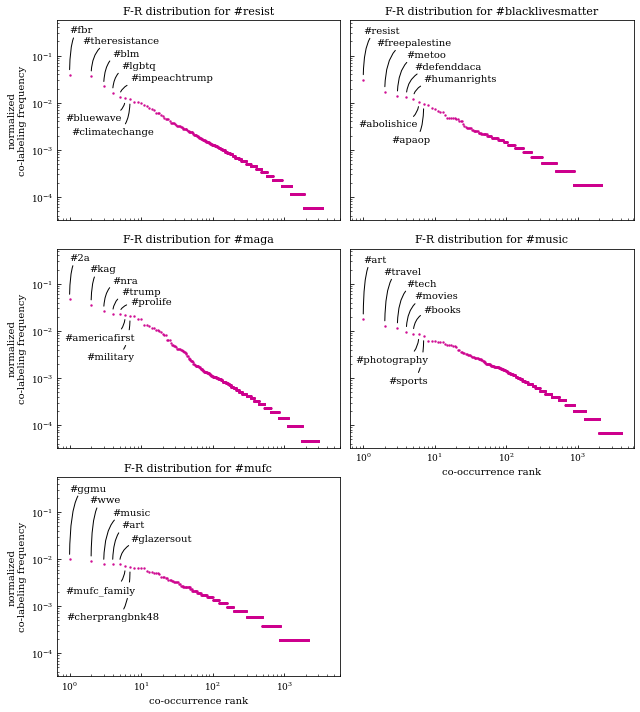

In [15]:
# Plot freq-rank for all anchor labels.

fig, axs = pyp.subplots(figsize=(9, 10), ncols=2, nrows=3, sharex=False, sharey=False)
axs = axs.ravel()

_plot_primetags = ['#resist', '#blacklivesmatter', '#maga', '#music', '#mufc']
_xlims = [np.inf, -np.inf]
_ylims = [np.inf, -np.inf]
for primetag, ax in zip(_plot_primetags, axs):

    primeht_cooc = d_hashtag_cooc[primetag]
    rank, count = zip(*enumerate(sorted(primeht_cooc.values(), reverse=True)))
    rank = np.array(rank)+1
    probs = np.array(count)/sum(count)

    pimson = np.array([170,0,88])/256.
    almond = np.array([255,181,80])/256.
    clblue = np.array([27,154,255])/256.
    pink = np.array([255,100,156])/256.
    magenta = np.array([206,0,142])/256.
    springgreen = np.array([109,200,54])/256.
    green = np.array([1,153,51])/256.
    turquoise = np.array([1,163,171])/256.
    lightred = np.array([255,150,175])/256.
    lavender = np.array([194,149,196])/256.
    ax.loglog(rank, probs, '.', color=magenta,
              alpha=0.8,
              label='data', markersize=3)

    ax.set_ylim(ax.get_ylim()[0], 0.19)

    labelcnt = 8
    top_cotags = [x[0] for x in sorted(primeht_cooc.items(),
                                       key=lambda x: x[1],
                                       reverse=True)][:labelcnt]
    if primetag == '#resist':
        labdiffs = [0.31, 0.17, 0.09, 0.045, 0.02, -0.0076, -0.0095]
        xyxs = [1, 1.5, 4, 5.2, 7., 5.4, 15]
    elif primetag == '#blacklivesmatter':
        labdiffs = [0.31, 0.17, 0.09, 0.045, 0.02, -0.007, -0.0078]
        xyxs = [1, 1.5, 4, 5.2, 7., 5.8, 8.7]
    elif primetag == '#maga':
        labdiffs = [0.31, 0.17, 0.09, 0.045, 0.02, -0.015, -0.018]
        xyxs = [1, 1.9, 4, 5.2, 7., 8.2, 8]
    elif primetag == '#music':
        labdiffs = [0.31, 0.17, 0.09, 0.045, 0.02, -0.006, -0.007]
        xyxs = [1, 1.9, 4, 5.2, 7., 8.2, 8]
    elif primetag == '#mufc':
        labdiffs = [0.31, 0.17, 0.09, 0.045, 0.02, -0.005, -0.0062]
        xyxs = [1, 1.9, 4, 5.2, 7., 8.2, 18]
    else:
        raise Exception('should not happen')
    for top_cotag, rk, prob, labdiff, xyx in zip(top_cotags, rank, probs, labdiffs, xyxs):
        """ax.annotate(top_cotag, xy=(rk, prob),
                    xytext=(0.03*rk + 0.02, 0.6 - 0.03*rk), textcoords='axes fraction',
                    arrowprops={'arrowstyle': '-',
                                'shrinkA': 5,
                                'shrinkB': 5})"""
        print(top_cotag)
        #if top_cotag in ['#bluewave', '#climatechange']:
        if rk in [6, 7]:
            ha = 'right'
            va = 'center'
            
        else:
            ha = 'left'
            va = 'center'
        bbox = None
        zorder = 0
        if rk == 6 and primetag not in ['#resist', '#blacklivesmatter']:
            bbox = {'facecolor': 'white', 'edgecolor': 'none', 'boxstyle': 'round'}
            zorder = 1
        ax.annotate(top_cotag, xy=(rk, prob),
                    xytext=(xyx, prob+labdiff),
                    arrowprops={'arrowstyle': '-',
                                'shrinkA': 1.5,
                                'shrinkB': 5,
                                'connectionstyle': "angle3,angleA=0,angleB=-90"},
                    ha=ha, va=va, bbox=bbox, zorder=zorder)

    ax.set_title('F-R distribution for {}'.format(primetag))
    
    ax.set_ylim(ax.get_ylim()[0], 0.56)
    
    xl = ax.get_xlim()
    if xl[0] < _xlims[0]:
        _xlims[0] = xl[0]
    if xl[1] > _xlims[1]:
        _xlims[1] = xl[1]
    yl = ax.get_ylim()
    if yl[0] < _ylims[0]:
        _ylims[0] = yl[0]
    if yl[1] > _ylims[1]:
        _ylims[1] = yl[1]
    
for ax in axs:
    ax.set_xlim(_xlims)
    ax.set_ylim(_ylims)
axs[-1].set_axis_off()
axs = axs.reshape(3, 2)
for ax in axs[:2,0]:
    ax.set_xticklabels([])
for ax in axs[:1,1]:
    ax.set_xticklabels([])
for ax in axs[:,1]:
    ax.set_yticklabels([])
axs[2,0].set_xlabel('co-occurrence rank')
axs[1,1].set_xlabel('co-occurrence rank')
for ax in axs[:,0]:
    ax.set_ylabel('normalized\nco-labeling frequency')

fig.tight_layout(w_pad=0.05, h_pad=0.02)

## Identity label autocorrelation

In [16]:
def lablabcorr(hashtag_sequence, period, maxdelta, deltabinsize=1, mindelta=1):
    """
    Label-label correlation, with optional binning.  Set deltabinsize=1 for no binning.
    
    Args:
      hashtag_sequence (list): sequence of individual hashtags
      period (int): length of tag history to include after any offset in the entire tag history
      maxdelta (int): maximum delta between tags to include
      offsets (list of ints): each offset in the entire tag history to take a period's length
        of tags after and calculate correlations for all deltas from mindelta up to maxdelta
      
    
    """
    
    _d_ht_idx = {}
    _hashtagidxs = []
    _idx = 0
    for ht in hashtag_sequence:
        if ht not in _d_ht_idx:
            _d_ht_idx[ht] = _idx
            _idx += 1
        _hashtagidxs.append(_d_ht_idx[ht])
    _hashtagidxs = np.array(_hashtagidxs, dtype=np.uint32)

    # Calculate Label-label correlation for each
    # delta-t from 1 to maxdelta.
    deltabins = np.arange(mindelta, maxdelta+1, deltabinsize)
    deltabin_corrsums = []
    deltabin_corrnumbers = []
    deltabin_correlations = []
    for j in range(len(deltabins)-1):
        deltabin0, deltabin1 = deltabins[j], deltabins[j+1]
        deltas = list(range(deltabin0, deltabin1))
        corrsums = []
        corrnumbers = []
        for delta in deltas:
            corrsums.append((_hashtagidxs[delta:] == _hashtagidxs[:-delta]).sum())
            corrnumbers.append(len(hashtag_sequence) - delta)
        deltabin_corrsums.append(sum(corrsums))
        deltabin_corrnumbers.append(sum(corrnumbers))
        deltabin_correlations.append(sum(corrsums)/sum(corrnumbers))

    # Get period F-R distribution and expected random-order
    # correlations using empirical period F-R distribution.
    rank, count = zip(*enumerate(sorted(Counter(_hashtagidxs).values(), reverse=True)))
    ranks = np.array(rank)+1
    probs = np.array(count)/sum(count)
    randomordercorrelation = (probs**2).sum()
    
    return deltabins, deltabin_correlations, deltabin_corrsums, deltabin_corrnumbers, randomordercorrelation

The code below repeatedly simulates a random-order label timeline for each anchor label and from this produces a autocorrelation null-model confidence interval band.  The paper uses a simulation count of 10,000, while the code below uses 100 (set by `randomorder_simcount`).  Simulating with 100 repetitions using the code in the next cell takes roughly 5 minutes in total, over all 5 anchor labels.

Alternatively, one can load an example set of simulations in the cell below.

In [ ]:
#%%timeit # If you use this cell magic incantation, reduce `randomorder_simcount` to something reasonable like 100.

# Simulate random-order updating.

randomorder_simcount = 100 # Increase to get fully-simulated CI bands.

set_maxdelta = None

deltabinsize = 1

d_anchorlabel_shufflecorrCIs = {pt: {} for pt in anchorlabels}
for pk, anchorlabel in enumerate(anchorlabels):
    
    
    anchorlabel_updates = d_anchorlabel_updates[anchorlabel]
    
    sim_correlations = []
    for simk in range(randomorder_simcount):
    
        _hashtagupdates = []
        for update in anchorlabel_updates:
            hts = list(update['Hashtags'] - set([anchorlabel])) # Remove prime label from update.
            if len(hts) > 0:
                np.random.shuffle(hts)
                _hashtagupdates.append(hts)
                
        # Scramble update order
        np.random.shuffle(_hashtagupdates)
        
        hashtag_sequence = list(chain(*_hashtagupdates))
        
        period = len(hashtag_sequence)
        if not set_maxdelta:
            maxdelta = period-1000 # at least 1K data points per correlation
        else:
            maxdelta = set_maxdelta
            
        # Get correlations.
        deltabins, deltabin_correlations, deltabin_corrsums, deltabin_corrnumbers, randomordercorrelation = \
                lablabcorr(hashtag_sequence, period, maxdelta, mindelta=1, deltabinsize=deltabinsize)
            
        sim_correlations.append(deltabin_correlations)
            
    pt_shufflecorrs_perdeltabin = np.percentile(np.vstack(sim_correlations),
                                                [2.5, 97.5],
                                                axis=0)
    shuffCIhis, shuffCIlos = pt_shufflecorrs_perdeltabin
    
    d_anchorlabel_shufflecorrCIs[anchorlabel]['deltabins'] = deltabins
    d_anchorlabel_shufflecorrCIs[anchorlabel]['shufflecorrCIs'] = [shuffCIhis, shuffCIlos]

    print(anchorlabel)
    sys.stdout.flush()
    
# Save.
"""
_savename = '_d_anchorlabel_shufflecorrs.pkl.bz2'

with bz2.open(_savename, mode='wb', compresslevel=9) as f:
    pickle.dump(d_anchorlabel_shufflecorrCIs, f)
"""


In [17]:
# Load example set of binned simulation CIs.

_savename = '_d_anchorlabel_shufflecorrs.pkl.bz2'

# Load.
with bz2.open(_savename, mode='rb', compresslevel=9) as f:
    d_anchorlabel_shufflecorrCIs = pickle.load(f)

In [18]:
def corr_plaw(x, a, delta):
    return a/(x + delta)

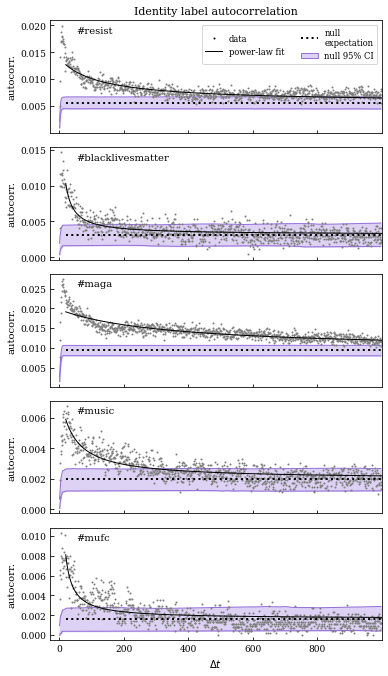

In [19]:
# Plot autocorrelations with null bands up to a limit.

fig, axs = pyp.subplots(figsize=(5.5, 9.5),
                            nrows=len(anchorlabels), ncols=1,
                            sharey=False, sharex=True)


set_maxdelta = 1000  # Defines maximum time delta plotted on x-axis.

deltabinsize = 1

fitxmin = 20
fitdeltabinsize = 1

plot_fit = True

corrcolor = 'tab:grey'

_shufcorrdict = d_anchorlabel_shufflecorrCIs

for pk, anchorlabel in enumerate(anchorlabels):
    
    anchorlabel_updates = d_anchorlabel_updates[anchorlabel]

    _hashtagupdates = []
    for update in anchorlabel_updates:
        hts = list(update['Hashtags'] - set([anchorlabel])) # Remove prime label from update.
        if len(hts) > 0:
            np.random.shuffle(hts)
            _hashtagupdates.append(hts)
    hashtag_sequence = list(chain(*_hashtagupdates))

    period = len(hashtag_sequence)
    if not set_maxdelta:
        maxdelta = period-1000 # at least 1K data points per correlation
    else:
        maxdelta = set_maxdelta
    
    # Get correlations.
    deltabins, deltabin_correlations, deltabin_corrsums, deltabin_corrnumbers, randomordercorrelation = \
            lablabcorr(hashtag_sequence, period, maxdelta, mindelta=1, deltabinsize=deltabinsize)

    # Get correlations for fit.
    fit_deltabins, fit_deltabin_correlations, fit_deltabin_corrsums, \
            fit_deltabin_corrnumbers, fit_randomordercorrelation = \
                lablabcorr(hashtag_sequence, period, maxdelta, mindelta=fitxmin, deltabinsize=fitdeltabinsize)
    # Fit power law autocorrelation function, with minimum delta at 10.
    xdata = fit_deltabins[:-1] # for deltabinsize=1 case!
    ydata = fit_deltabin_correlations - fit_randomordercorrelation # subtract the random-order base
    popt, pcov = curve_fit(corr_plaw, xdata, ydata)

    # Plot.

    ax = axs[pk]
    
    ## Plot random-order simulation first.
    
    shuffle_deltabin_x = _shufcorrdict[anchorlabel]['deltabins'][:maxdelta]
    shuffCIhis, shuffCIlos = _shufcorrdict[anchorlabel]['shufflecorrCIs'][:maxdelta]
    
    ### Bin after the first few to get rid of the CI boundary roughness.
    ### (Visual rhetoric. The occasional roughness distracts from the scatter of
    ### empirical data when it is overlaid.)
    _shufbin_thresh = 12
    shuffle_deltabin_x_binned = list(shuffle_deltabin_x[:_shufbin_thresh])
    shuffCIlos_binned = list(shuffCIlos[:_shufbin_thresh])
    shuffCIhis_binned = list(shuffCIhis[:_shufbin_thresh])
    _st = _shufbin_thresh
    _sbinsize = 20
    while _st < len(shuffle_deltabin_x):
        shuffle_deltabin_x_binned.append(np.mean(shuffle_deltabin_x[_st:_st+_sbinsize]))
        shuffCIlos_binned.append(np.mean(shuffCIlos[_st:_st+_sbinsize]))
        shuffCIhis_binned.append(np.mean(shuffCIhis[_st:_st+_sbinsize]))
        _st += _sbinsize
    
    _fbcol = np.array([222,211,244])/256.
    ax.fill_between(shuffle_deltabin_x_binned, y1=shuffCIlos_binned, y2=shuffCIhis_binned,
                    color=_fbcol)
    ax.plot(shuffle_deltabin_x_binned, shuffCIhis_binned, 'mediumpurple', linewidth=1)
    ax.plot(shuffle_deltabin_x_binned, shuffCIlos_binned, 'mediumpurple', linewidth=1)

    deltabin_x = deltabins[:-1] # for deltabinsize=1 case!

    ax.plot(deltabin_x, deltabin_correlations, '.', markersize=2, color=corrcolor, alpha=1,
            rasterized=True)

    ax.plot([fitxmin, maxdelta], [fit_randomordercorrelation]*2, ':k')#, label='random order\nexpectation')

    # Plot power law fit.
    if plot_fit:
        yfit = corr_plaw(xdata, *popt)
        yfit = yfit + fit_randomordercorrelation
        ax.plot(xdata, yfit, 'k', linewidth=1, linestyle='-')#, label='power-law fit')

    ax.annotate(anchorlabel, xy=(0.08, 0.95), xycoords='axes fraction',
                va='top', ha='left')

    ax.set_xlim(-30, max(deltabin_x))


leglinehandles = [mpl.lines.Line2D([0], [0], marker='.', linewidth=0, color='k', markersize=2, alpha=1),
                      mpl.lines.Line2D([0], [0], linewidth=1, color='k', alpha=1),
                      mpl.lines.Line2D([0], [0], linewidth=2, linestyle=':', color='k', alpha=1),
                      mpl.patches.Rectangle(xy=(0., 0.), width=1., height=1.,
                                            facecolor=_fbcol,
                                            edgecolor='mediumpurple')]
leglinelabs = ['data',
               'power-law fit',
               'null\nexpectation',
               'null 95% CI']
leg = axs[0].legend(leglinehandles, leglinelabs,
                        loc='upper right',
                        ncol=2,
                        fontsize='small')#,
"""                        bbox_to_anchor=[1.15, 1.06],
                        facecolor='white', framealpha=1, edgecolor='k',
                        fontsize='small')"""

axs[0].set_title('Identity label autocorrelation')
for ax in axs:
    ax.set_ylabel('autocorr.')
axs[-1].set_xlabel('$\Delta t$')
    
fig.tight_layout()

Note that the random shuffling of labels within profile updates produces minor variations from the figures in the main paper. 

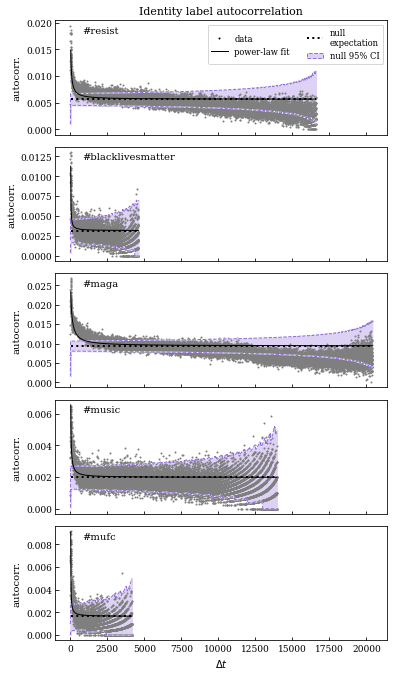

In [20]:
# Plot autocorrelations with null bands to the full range of time delta.

fig, axs = pyp.subplots(figsize=(5.5, 9.5),
                            nrows=len(anchorlabels), ncols=1,
                            sharey=False, sharex=True)


set_maxdelta = None

deltabinsize = 1

fitxmin = 20
fitdeltabinsize = 1

plot_fit = True

corrcolor = 'tab:grey'

_shufcorrdict = d_anchorlabel_shufflecorrCIs

for pk, anchorlabel in enumerate(anchorlabels):
    
    anchorlabel_updates = d_anchorlabel_updates[anchorlabel]

    _hashtagupdates = []
    for update in anchorlabel_updates:
        hts = list(update['Hashtags'] - set([anchorlabel])) # Remove prime label from update.
        if len(hts) > 0:
            np.random.shuffle(hts)
            _hashtagupdates.append(hts)
    hashtag_sequence = list(chain(*_hashtagupdates))

    period = len(hashtag_sequence)
    if not set_maxdelta:
        maxdelta = period-1000 # at least 1K data points per correlation
    else:
        maxdelta = set_maxdelta
    
    # Get correlations.
    deltabins, deltabin_correlations, deltabin_corrsums, deltabin_corrnumbers, randomordercorrelation = \
            lablabcorr(hashtag_sequence, period, maxdelta, mindelta=1, deltabinsize=deltabinsize)

    # Get correlations for fit.
    fit_deltabins, fit_deltabin_correlations, fit_deltabin_corrsums, \
            fit_deltabin_corrnumbers, fit_randomordercorrelation = \
                lablabcorr(hashtag_sequence, period, maxdelta, mindelta=fitxmin, deltabinsize=fitdeltabinsize)
    # Fit power law autocorrelation function, with minimum delta at 10.
    xdata = fit_deltabins[:-1] # for deltabinsize=1 case!
    ydata = fit_deltabin_correlations - fit_randomordercorrelation # subtract the random-order base
    popt, pcov = curve_fit(corr_plaw, xdata, ydata)

    # Plot.

    ax = axs[pk]
    
    ## Plot random-order simulation first.
    
    shuffle_deltabin_x = _shufcorrdict[anchorlabel]['deltabins'][:-1]
    shuffCIhis, shuffCIlos = _shufcorrdict[anchorlabel]['shufflecorrCIs']
    
    ### Bin after the first few to get rid of the CI boundary roughness (visual rhetoric.
    ### the occasional roughness distracts from the scatter of empirical data when it is overlaid)
    _shufbin_thresh = 20
    shuffle_deltabin_x_binned = list(shuffle_deltabin_x[:_shufbin_thresh])
    shuffCIlos_binned = list(shuffCIlos[:_shufbin_thresh])
    shuffCIhis_binned = list(shuffCIhis[:_shufbin_thresh])
    _st = _shufbin_thresh
    _sbinsize = 12
    while _st < len(shuffle_deltabin_x):
        shuffle_deltabin_x_binned.append(np.mean(shuffle_deltabin_x[_st:_st+_sbinsize]))
        shuffCIlos_binned.append(np.mean(shuffCIlos[_st:_st+_sbinsize]))
        shuffCIhis_binned.append(np.mean(shuffCIhis[_st:_st+_sbinsize]))
        _st += _sbinsize
    shuffle_deltabin_x_binned.append(shuffle_deltabin_x[-1])
    shuffCIlos_binned.append(shuffCIlos[-1])
    shuffCIhis_binned.append(shuffCIhis[-1])
    
    _fbcol = np.array([222,211,244])/256.
    ax.fill_between(shuffle_deltabin_x_binned, y1=shuffCIlos_binned, y2=shuffCIhis_binned,
                    color=_fbcol)
    

    deltabin_x = deltabins[:-1] # for deltabinsize=1 case!

    ax.plot(deltabin_x, deltabin_correlations, '.', markersize=2, color=corrcolor, alpha=1,
            rasterized=True)
    
    # Plot a mostly-transparent CI fill on top of empirical correlations, but below the CI
    # boundary lines.  This should help define the CI for when alpha is supported in images,
    # but if not then the fully opaque CI underlying the empirical scatter is still there.
    ax.fill_between(shuffle_deltabin_x_binned, y1=shuffCIlos_binned, y2=shuffCIhis_binned,
                    color=_fbcol, alpha=0.3)
    
    # Plot null CI lines on top of empirical correlations, to show CI that would be obscured
    # by empirical corr.
    ax.plot(shuffle_deltabin_x_binned, shuffCIhis_binned, 'ghostwhite', linewidth=1)
    ax.plot(shuffle_deltabin_x_binned, shuffCIlos_binned, 'ghostwhite', linewidth=1)
    ax.plot(shuffle_deltabin_x_binned, shuffCIhis_binned, 'mediumpurple', linewidth=1, linestyle='--')
    ax.plot(shuffle_deltabin_x_binned, shuffCIlos_binned, 'mediumpurple', linewidth=1, linestyle='--')

    ax.plot([fitxmin, maxdelta], [fit_randomordercorrelation]*2, ':k')#, label='random order\nexpectation')

    # Plot power law fit.
    if plot_fit:
        yfit = corr_plaw(xdata, *popt)
        yfit = yfit + fit_randomordercorrelation
        ax.plot(xdata, yfit, 'k', linewidth=1, linestyle='-')#, label='power-law fit')

    ax.annotate(anchorlabel, xy=(0.08, 0.95), xycoords='axes fraction',
                va='top', ha='left')


leglinehandles = [mpl.lines.Line2D([0], [0], marker='.', linewidth=0, color='k', markersize=2, alpha=1),
                      mpl.lines.Line2D([0], [0], linewidth=1, color='k', alpha=1),
                      mpl.lines.Line2D([0], [0], linewidth=2, linestyle=':', color='k', alpha=1),
                      mpl.patches.Rectangle(xy=(0., 0.), width=1., height=1.,
                                            facecolor=_fbcol,
                                            edgecolor='mediumpurple', linestyle='--')]
leglinelabs = ['data',
               'power-law fit',
               'null\nexpectation',
               'null 95% CI']
leg = axs[0].legend(leglinehandles, leglinelabs,
                        loc='upper right',
                        ncol=2,
                        fontsize='small')

axs[0].set_title('Identity label autocorrelation')
for ax in axs:
    ax.set_ylabel('autocorr.')
axs[-1].set_xlabel('$\Delta t$')
    
fig.tight_layout()

## Simulation

In [21]:
def make_simingreds(taggingclassname, ps_sample, 
                    n0s_sample, taus_sample, d_hashtag_cooc,
                    tagprofiles, simcount, T, searchiternum, save_histories):

    ps_grid, taus_grid, n0s_grid = np.meshgrid(ps_sample, taus_sample, n0s_sample)

    param_combos = list([dict(zip(['p', 'tau', 'n0'], combo)) for combo in \
                         zip(ps_grid.flatten(), taus_grid.flatten(), n0s_grid.flatten())])

    simingreds = {"taggingclassname": taggingclassname,
                  "d_hashtag_cooc": d_hashtag_cooc,
                  "tagprofiles": tagprofiles,
                  "simcount": simcount,
                  "T": T,
                  "searchiternum": searchiternum,
                  "param_combos": param_combos,
                  "save_histories": save_histories}

    return simingreds

In [22]:
def make_latticesearch_dir(dirpath, simingreds, anchorlabels):

    os.mkdir(dirpath)
    
    for tag, tag_simingreds in simingreds.items():
        fname = 'simingreds_{}.pkl'.format(tag)
        with open(os.path.join(dirpath, fname), mode='wb') as f:
            pickle.dump(tag_simingreds, f)
        
    with open(os.path.join(dirpath, 'primetagslist.txt'), mode='w') as f:
        for anchorlabel in anchorlabels:
            f.write(anchorlabel + "\n")

In [23]:
def grouper(iterable, n, fillvalue=None):
    """
    Collect data into fixed-length chunks or blocks, with the last chunk
    containing the remainder.

    """
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    # The above is fixed with my yield+filter below,
    # giving the reduced-size chunk at the end.

    arguments = [iter(iterable)]*n
    
    for g in zip_longest(*arguments, fillvalue=fillvalue):
        yield filter(lambda x: x != fillvalue, g)

## Simulations

In [24]:
def get_taus_sample(taumax, tau_numsteps):
    return sorted(set(([0] + list(map(lambda x: int(np.floor(x)),
                                      np.logspace(0, np.log10(taumax), tau_numsteps))))))

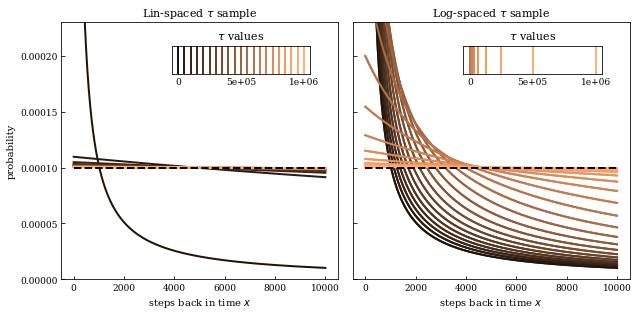

In [25]:
fig, axs = pyp.subplots(figsize=(9, 4.5), ncols=2, sharey=True)

histlen = 10000

x = np.linspace(1, histlen+1, histlen)

taumin, taumax = [0, 100*histlen]

tau_numsteps = 21

# Lin-spaced tau sample ==========================

ax = axs[0]

#tau_step = int(np.ceil(taumax/tau_numsteps))
#taus_sample = np.arange(taumin, taumax, tau_step)

taus_sample = [int(k) for k in np.linspace(taumin, taumax, tau_numsteps)]

colors = mpl.cm.copper(np.linspace(0.1, 0.9, len(taus_sample)))

# First axes tau color range subplot.
ax2 = ax.inset_axes([0.4, 0.8, 0.5, 0.11])
for tau, color in zip(taus_sample, colors):

    ypre = np.absolute(1/(x + tau))
    y = ypre/ypre.sum()

    ax.plot(x, y, color=color, label=r'$\tau=$' + '{:,}'.format(tau))
    
    ax2.plot([tau]*2, [0,1], color=color)
ax2.set_xticks([taus_sample[0], (taus_sample[0] + taus_sample[-1])/2, taus_sample[-1]])
ax2.set_xticklabels([str(taus_sample[0]),
                     '{:,.0e}'.format((taus_sample[0] + taus_sample[-1])/2),
                     '{:,.0e}'.format(taus_sample[-1])])
ax2.set_ylim(0,1)
ax2.set_yticks([])
ax2.set_title(r'$\tau$ values')
    
ax.plot([1, histlen+1], [1/histlen]*2, '--k', label='uniform')

ax.set_ylim(0, (1/histlen)*2.3)

#ax.set_yscale('log')

#legout = ax.legend(loc='upper right', bbox_to_anchor=(1., 1.), ncol=2, fontsize='x-small')


ax.set_ylabel('probability')
ax.set_xlabel(r'steps back in time $x$')
ax.set_title(r'Lin-spaced $\tau$ sample')

# Log-spaced tau sample ==========================

ax = axs[1]

taus_sample = get_taus_sample(taumax, tau_numsteps)

colors = mpl.cm.copper(np.linspace(0.1, 0.9, len(taus_sample)))

# First axes tau color range subplot.
ax2 = ax.inset_axes([0.4, 0.8, 0.5, 0.11])
for tau, color in zip(taus_sample, colors):

    ypre = np.absolute(1/(x + tau))
    y = ypre/ypre.sum()

    ax.plot(x, y, color=color, label=r'$\tau=$' + '{:,}'.format(tau))
    
    ax2.plot([tau]*2, [0,1], color=color)
ax2.set_xticks([taus_sample[0], (taus_sample[0] + taus_sample[-1])/2, taus_sample[-1]])
ax2.set_xticklabels([str(taus_sample[0]),
                     '{:,.0e}'.format((taus_sample[0] + taus_sample[-1])/2),
                     '{:,.0e}'.format(taus_sample[-1])])
ax2.set_ylim(0,1)
ax2.set_yticks([])
ax2.set_title(r'$\tau$ values')

for tau, color in zip(taus_sample, colors):

    ypre = np.absolute(1/(x + tau))
    y = ypre/ypre.sum()

    ax.plot(x, y, color=color, label=r'$\tau=$' + '{:,}'.format(tau))
    
ax.plot([1, histlen+1], [1/histlen]*2, '--k', label='uniform')

ax.set_ylim(0, (1/histlen)*2.3)

ax.set_xlabel(r'steps back in time $x$')
ax.set_title(r'Log-spaced $\tau$ sample')

fig.tight_layout()

In [26]:
def load_simouts_results(picklepath):
    assert picklepath[-4:] == '.pkl', 'Must be a .pkl file.'
    with open(picklepath, mode='rb') as f:
        paramcombo_simoutsdicts = pickle.load(f)
    return paramcombo_simoutsdicts

In [27]:
def load_tag_paramsearchiter_results(dirpath, tag, limit_n0=None):
    """
    Load simulation parameters/scores over all search iterations
    for the particular tag in directory at dirpath.
    
    """
    
    glob_fpath_str = '{}_searchiter*_paramcombosimoutsdicts.pkl'.format(tag)
    d_primetagsearchiter_simouts = {}
    for fpath in glob(os.path.join(dirpath, glob_fpath_str)):
        paramcombo_simoutsdicts = load_simouts_results(fpath)
        
        searchiter = int(re.search('_searchiter[0-9]+_',
                              os.path.split(fpath)[-1]).group()[11:-1])
        
        simouts = []
        for paramcombo_simoutsdict in paramcombo_simoutsdicts:
            paramcombo_simouts = \
                    [paramcombo_simoutsdict['paramcombo'][k] for k in ['p', 'tau', 'n0']] + \
                                      [paramcombo_simoutsdict['score']]
            
            if limit_n0:
                if paramcombo_simouts[2] in limit_n0:
                    simouts.append(paramcombo_simouts)
            else:
                simouts.append(paramcombo_simouts)
        
        d_primetagsearchiter_simouts[searchiter] = simouts
    
    return d_primetagsearchiter_simouts

In [28]:
def load_groupdir_simouts(groupdirpath, first_n_tags=None, limit_n0=None):
    with open(os.path.join(groupdirpath, 'primetagslist.txt')) as f:
        tags = [line.strip() for line in f]
    if first_n_tags:
        tags = tags[:first_n_tags]
    group_d_primetag_paramlatticeouts = {}
    for tag in tags:
        group_d_primetag_paramlatticeouts[tag] = \
                load_tag_paramsearchiter_results(groupdirpath, tag, limit_n0=limit_n0)

    print('{} loaded.'.format(groupdirpath))
    sys.stdout.flush()
    return group_d_primetag_paramlatticeouts

In [29]:
def load_regrouped_primetag_paramlatticesearch(group_umbrella_dirpath,
                                               first_n_tags=None, limit_n0=None):
    """
    group_umbrella_dirpath contains a number of `group_0`, `group_1`, etc.
    subdirectories.
    
    first_n_tags (int): limits loading to the first n tags in every `group_*/primetagslist.txt`.
    
    """
    
    groupdirpaths = []
    for groupdirpath in glob(os.path.join(group_umbrella_dirpath, 'group_*')):
        if '.log' == groupdirpath[-4:]:
            continue
        
        groupdirpaths.append(groupdirpath)
    
    d_primetag_paramlatticeouts = {}
    for groupdirpath in groupdirpaths:
        group_d_primetag_paramlatticeouts = \
                load_groupdir_simouts(groupdirpath,
                                      first_n_tags=first_n_tags,
                                      limit_n0=limit_n0)
        for k, v in group_d_primetag_paramlatticeouts.items():
            d_primetag_paramlatticeouts[k] = v
            
    return d_primetag_paramlatticeouts

### Run augmented Yule model and load results

The following cell creates an umbrella directory `TagSimulator_pnew_unboundvoc_simulation` to place simulations in, and creates subdirectories for each anchor label.  Navigate to the umbrella directory and run the bash script using `bash run.sh` to run each simulation in parallel.  Subsequent cells in this notebook load those simulation results and plot figures found in the paper.

In [112]:
# Lattice search setup for any prime label: augmented Yule model.

taggingclassname = "TagSimulator_pnew_unboundvoc"

# Make local directory to place simulation results.
group_umbrella_dirpath = "./{}_simulation".format(taggingclassname)

save_histories = False

os.mkdir(group_umbrella_dirpath)

primelabels_tosim = anchorlabels

simcount = 30 # Number of simulations to perform for a parameter combination.

searchiternum = 80 # Number of searches to perform over all parameter combinations.

# Linearly-spaced p sample.
pmin, pmax = [0.01, 0.8]
p_numsteps = 12
ps_sample = np.linspace(pmin, pmax, p_numsteps)

# Find maximum number of profile occurrences for any prime tag.
max_T = 0
for label in primelabels_tosim:
    label_T = d_anchorlabel_numcolabels[label]
    if label_T > max_T:
        max_T = label_T
        
taumax = 100*max_T
tau_numsteps = 15 # +1 for true tau sample, because of function get_taus_sample
taus_sample = get_taus_sample(taumax, tau_numsteps)

nproc = 5 # Set up the bash running script to simulate for the 5 prime labels in parallel,
          # with separate results directories.
for _i, ptg in enumerate(grouper(primelabels_tosim, int(np.ceil(len(primelabels_tosim)/nproc)))):
    simgroupdirpath = os.path.join(group_umbrella_dirpath, "group_{}".format(_i))
    ptg = list(ptg)
    print('--', _i)
    print(ptg)
    
    d_label_simingreds = {}
    for label in ptg:
        
        label_T = d_anchorlabel_numcolabels[label]
        
        # log-spaced n0 from 1 to 0.01T
        label_n0s_sample = [int(k) for k in np.logspace(0, np.log10(0.01*label_T), 3)]

        simingreds = make_simingreds(taggingclassname, ps_sample, 
                             label_n0s_sample, taus_sample, d_hashtag_cooc,
                             hashtagupdates, simcount, label_T, searchiternum, save_histories)
        d_label_simingreds[label] = simingreds
        
    make_latticesearch_dir(simgroupdirpath, d_label_simingreds, ptg)

# Create bash running script and place appropriate location.
runscript = "for dirpath in ./group_*; do\n" + \
        "    python3 ../run_semiotic_tag_model.py $dirpath &\ndone"
with open(os.path.join(group_umbrella_dirpath, "run.sh"), mode='w') as f:
    f.write(runscript)

-- 0
['#resist']
-- 1
['#blacklivesmatter']
-- 2
['#maga']
-- 3
['#music']
-- 4
['#mufc']


In [32]:
# Load augmented Yule-Simon model results and simulation ingredients.

first_n_tags = None

d_primetag_paramlatticeouts = \
        load_regrouped_primetag_paramlatticesearch(group_umbrella_dirpath,
                                                   first_n_tags=first_n_tags)

print('\n')
for primetag in anchorlabels:
    
    print('{}: {:,} full lattice searches'.format(primetag, len(d_primetag_paramlatticeouts[primetag])))

./TagSimulator_pnew_unboundvoc_simulation/group_0 loaded.
./TagSimulator_pnew_unboundvoc_simulation/group_1 loaded.
./TagSimulator_pnew_unboundvoc_simulation/group_2 loaded.
./TagSimulator_pnew_unboundvoc_simulation/group_3 loaded.
./TagSimulator_pnew_unboundvoc_simulation/group_4 loaded.


#resist: 80 full lattice searches
#blacklivesmatter: 80 full lattice searches
#maga: 80 full lattice searches
#music: 80 full lattice searches
#mufc: 80 full lattice searches


Note that if the "full lattice search" count printed above doesn't match `searchiternum`, you probably need to wait longer for simulations to finish.

## Simulation results and plotting

Obtain the best parameter combination per anchor label from lattice search above, then re-simulate with higher iterations for plots.  One can run the code below or load results in the subsequent cell.

In [44]:
from semiotic_tagging_models \
        import TagSimulator_pnew_unboundvoc

In [45]:
from semiotic_tagging_models import get_simul_countsprobs_perrank

def simulate_FASTCLASS(T, p_param, tau_param, n0_param, TagSimClass, simcount,
                                      return_histories=False):
    
    TagSim = TagSimClass(T, p_param, tau_param, n0_param)
    
    seeds = []
    for k in range(simcount):
        seeds.append(int.from_bytes(os.urandom(4), byteorder='little'))

    sim_tag_histories = [TagSim.simulate(seed) \
                         for seed in seeds]

    simul_counts_perrank, simul_probs_perrank = \
            get_simul_countsprobs_perrank(sim_tag_histories)
    
    if return_histories:
        return simul_counts_perrank, simul_probs_perrank, sim_tag_histories
    else:
        return simul_counts_perrank, simul_probs_perrank

In [46]:
def get_best_params_simulate_FASTCLASS(primetag, d_primetagsearchiter_simouts,
                                       T, simcount, TagSimClass,
                                       n0_value=None):
    
    # Get best params =====

    bestitems = []
    for searchiter, simouts in d_primetagsearchiter_simouts.items():
        
        if n0_value:
            n0_value_simouts = list(filter(lambda x: x[2] == n0_value, simouts))

            try:
                _ps, _taus, _n0s, _scores = zip(*n0_value_simouts)
            except:
                avail_n0s = sorted(set([x[2] for x in simouts]))
                raise Exception('Available n0s: {}'.format(avail_n0s))
        else:
            _ps, _taus, _n0s, _scores = zip(*simouts)

        lowest_error_ind = np.argmin(_scores)
        _plowest, _taulowest, _n0lowest, _scorelowest = \
                _ps[lowest_error_ind], _taus[lowest_error_ind], _n0s[lowest_error_ind], _scores[lowest_error_ind]
        bestitems.append((_plowest, _taulowest, _n0lowest, _scorelowest))
        
    bestps, besttaus, bestn0s, bestscores = zip(*bestitems)
    bestparams_persearchiter = {'bestps': bestps,
                                'besttaus': besttaus,
                                'bestn0s': bestn0s,
                                'bestscores': bestscores}
    
    # Get the param values searched over.
    if n0_value:
        n0s_searched = [n0_value]
    else:
        n0s_searched = sorted(set([t[2] for t in d_primetagsearchiter_simouts[0]]))
    taus_searched = sorted(set([t[1] for t in d_primetagsearchiter_simouts[0]]))
    ps_searched = sorted(set([t[0] for t in d_primetagsearchiter_simouts[0]]))

    
    ## Get the best parameters overall (including the multiple parameter searches)
    lowest_error_overall_ind = np.argmin(bestscores)
    _p_alllowest, _tau_alllowest, _n0_alllowest, _score_alllowest = \
            bestps[lowest_error_overall_ind], \
            besttaus[lowest_error_overall_ind], \
            bestn0s[lowest_error_overall_ind], \
            bestscores[lowest_error_overall_ind]
            
    overallbestparams = {'primetag': primetag,
                  'n0': _n0_alllowest,
                  'p': _p_alllowest,
                  'tau': _tau_alllowest,
                  'score': _score_alllowest}
    
    n0_param = _n0_alllowest
    p_param = _p_alllowest
    tau_param = _tau_alllowest

    simul_counts_perrank, simul_probs_perrank = simulate_FASTCLASS(T,
                                                                   p_param,
                                                                   tau_param,
                                                                   n0_param,
                                                                   TagSimClass,
                                                                   simcount)
        
    return (overallbestparams, bestparams_persearchiter, simul_counts_perrank, simul_probs_perrank)

In [47]:
# Get best parameter simulation F-R results

primetag_overallbestparams = []

simcount = 250

d_primetag_bestparamsimulationouts = {} # Simulate using the best parameter comination, record.
d_primetag_partialsimingreds = {} # including all sim ingreds would take too much space
groupdirpaths = filter(lambda x: x[-4:] != '.log', glob(os.path.join(group_umbrella_dirpath, 'group_*')))
for groupdirpath in groupdirpaths:
    
    with open(os.path.join(groupdirpath, 'primetagslist.txt'), mode='r') as f:
        groupdir_primetags = [ln.strip() for ln in f]
        
    for primetag in groupdir_primetags:
        
        d_primetagsearchiter_simouts = d_primetag_paramlatticeouts[primetag]
        
        tag_simingreds_path = os.path.join(groupdirpath, 'simingreds_{}.pkl'.format(primetag))
        with open(tag_simingreds_path, mode='rb') as f:
            tag_simingreds = pickle.load(f)
            
            d_primetag_partialsimingreds[primetag] = {key: tag_simingreds[key] for key in ['taggingclassname',
                                                                                           'simcount',
                                                                                           'T',
                                                                                           'searchiternum']}
            
            T = tag_simingreds['T']
        
        overallbestparams, bestparams_persearchiter, simul_counts_perrank, simul_probs_perrank = \
                get_best_params_simulate_FASTCLASS(primetag,
                                                      d_primetagsearchiter_simouts,
                                                      T,
                                                      simcount,
                                                      TagSimulator_pnew_unboundvoc)
        
        d_primetag_bestparamsimulationouts[primetag] = (overallbestparams,
                                                         bestparams_persearchiter,
                                                         simul_counts_perrank,
                                                         simul_probs_perrank)
        
        primetag_overallbestparams.append(overallbestparams)
        print(primetag)
        sys.stdout.flush()
        


#resist
#blacklivesmatter
#maga
#music
#mufc


In [49]:
# Save best parameter simulation F-R results.

fname = 'bestparamsim_FRresults.pkl.bz2'
"""
with bz2.open(fname, mode='wb', compresslevel=9) as f:
    pickle.dump([d_primetag_bestparamsimulationouts,
                 d_primetag_partialsimingreds,
                 primetag_overallbestparams],
                f)
"""

# Load best parameter simulation F-R results.
with bz2.open(fname, mode='rb', compresslevel=9) as f:
    d_primetag_bestparamsimulationouts, \
            d_primetag_partialsimingreds, \
                primetag_overallbestparams = pickle.load(f)

In [50]:
def plot_quants_2Dhist(q0, q1, fig, ax, make_cbar=True, xbins=None, ybins=None,
                       cbar_axis=False, cbar_orientation='vertical',
                       cmap=None, vmin=None, vmax=None, alpha=1., zorder=None):
    
    q0max = q0.max()
    q1max = q1.max()
    maxmax = max(q0max, q1max)
    q0min = q0.min()
    q1min = q1.min()
    
    if type(xbins) == type(None):
        q0bins = np.linspace(q0min-0.001, q0max+0.001, 30)
    else:
        q0bins = xbins
    if type(ybins) == type(None):
        q1bins = np.linspace(q1min-0.001, q1max+0.001, 30)
    else:
        q1bins = ybins
    
    H, xedges, yedges = np.histogram2d(q0,
                                       q1,
                                       bins=[q0bins, q1bins])

    # H needs to be rotated and flipped
    H = np.rot90(H)
    H = np.flipud(H)

    # Mask zeros
    Hmasked = np.ma.masked_where(H==0,H) # Mask pixels.
    
    # Plot 2D histogram using pcolor
    pcolm = ax.pcolormesh(xedges,yedges,Hmasked,
                          cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha, zorder=zorder)
    
    if make_cbar:
        if cbar_axis:
            cbar = fig.colorbar(pcolm, cax=cbar_axis, orientation=cbar_orientation)  
        else:
            cbar = fig.colorbar(pcolm, ax=ax, orientation=cbar_orientation)
        cbar.ax.set_ylabel('counts')
    
    if make_cbar:
        return H, cbar
    else:
        return H

In [51]:
def plot_meanrealFR_ptausearch_logtauscan_landscapeonly(axs, primetagsearchiter_simouts, overallbestparams,
                                                        bestparams_persearchiter,
                               simul_probs_perrank, n0_value=None,
                               add_multisimhist=False, multisim_max=None, multisim_cmap=mpl.cm.summer,
                               annot_topright=False,
                               realmarker='-', realmarkersize=10, CIfill=True, CIstep=False, CIsteplim=None,
                               logp=False, annot_primetag=None,
                               annot_fontsize=None, annot_error=True, rasterized=False):
    
    if n0_value:
        n0s_searched = [n0_value]
    else:
        n0s_searched = sorted(set([t[2] for t in primetagsearchiter_simouts[0]]))
    taus_searched = sorted(set([t[1] for t in primetagsearchiter_simouts[0]]))
    ps_searched = sorted(set([t[0] for t in primetagsearchiter_simouts[0]]))

    ps_grid, taus_grid, n0s_grid = np.meshgrid(ps_searched, taus_searched, n0s_searched)

    tau_min = min(taus_searched)
    tau_max = max(taus_searched)
    p_min = min(ps_searched)

    p_step = ps_searched[1] - ps_searched[0]

    tau_numsteps = len(taus_searched)
    p_numsteps = len(ps_searched)
    
    bestps = bestparams_persearchiter['bestps']
    besttaus = bestparams_persearchiter['besttaus']

    bestn0s = bestparams_persearchiter['bestn0s']
    bestscores = bestparams_persearchiter['bestscores']
    
    # Modal best p & tau
    modal_bestptau_p, modal_bestptau_tau = \
            sorted(Counter(zip(bestps, besttaus)).items(),
                   key=lambda x: x[1], reverse=True)[0][0]

    # Plot freq-rank =====

    ax = axs[0]

    eb_ranks = []
    eb_means = []
    eb_stds = []
    eb_CIlos = []
    eb_CIhis = []
    for rr, sp_pr in enumerate(simul_probs_perrank):

        rank = rr + 1
        eb_ranks.append(rank)
        eb_means.append(np.mean(sp_pr))
        eb_stds.append(np.std(sp_pr))

        CIlo, CIhi = np.percentile(sp_pr, q=[100*alpha/2, 100*(1-alpha/2)])
        eb_CIlos.append(CIlo)
        eb_CIhis.append(CIhi)

    if CIstep:
        
        if CIsteplim:
            steplim = CIsteplim
        else:
            steplim = 200
        
        for eb_k, (eb_rank, CIlo, CIhi) in enumerate(zip(eb_ranks[:steplim],
                                                         eb_CIlos[:steplim],
                                                         eb_CIhis[:steplim])):
        
            ax.plot([eb_rank-0.5, eb_rank+0.5], [CIlo]*2,
                    color='k', linestyle='-', linewidth=0.5,
                    alpha=1)
            ax.plot([eb_rank+0.5]*2, [CIlo, eb_CIlos[eb_k+1]],
                    color='k', linestyle='-', linewidth=0.5,
                    alpha=1)
            ax.plot([eb_rank-0.5, eb_rank+0.5], [CIhi]*2,
                    color='k', linestyle='-', linewidth=0.5,
                    alpha=1)
            ax.plot([eb_rank+0.5]*2, [CIhi, eb_CIhis[eb_k+1]],
                    color='k', linestyle='-', linewidth=0.5,
                    alpha=1)
        
    else:
        
        if CIfill:
            ax.fill_between(eb_ranks, y1=eb_CIlos, y2=eb_CIhis, color='k',
                            label='{}% CI'.format(int(100*(1-alpha))),
                            alpha=0.1)
        ax.plot(eb_ranks, eb_CIlos,
                color='k', linestyle='-', linewidth=0.5,
                alpha=1)
        ax.plot(eb_ranks, eb_CIhis,
                color='k', linestyle='-', linewidth=0.5,
                alpha=1)
    ax.plot(eb_ranks, eb_means, '.',
            markersize=2, color='k',
            label='simulation\nmean', alpha=0.6, rasterized=rasterized)
    
    # Plot real freq-rank
    
    primeht_cooc = d_hashtag_cooc[primetag]
    rank, count = zip(*enumerate(sorted(primeht_cooc.values(), reverse=True)))
    rank = np.array(rank)+1
    probs = np.array(count)/sum(count)

    pimson = np.array([170,0,88])/256.
    almond = np.array([255,181,80])/256.
    clblue = np.array([27,154,255])/256.
    pink = np.array([255,100,156])/256.
    magenta = np.array([206,0,142])/256.
    springgreen = np.array([109,200,54])/256.
    green = np.array([1,153,51])/256.
    turquoise = np.array([1,163,171])/256.
    lightred = np.array([255,150,175])/256.
    lavender = np.array([194,149,196])/256.
    ax.loglog(rank, probs, realmarker, markersize=realmarkersize,
              color=magenta,
              alpha=0.8,
              label='data',
              rasterized=rasterized)

    _n0_alllowest = overallbestparams['n0']
    _p_alllowest = overallbestparams['p']
    _tau_alllowest = overallbestparams['tau']
    _score_alllowest = overallbestparams['score']
    if n0_value:
        annotation = r'$n_0$: ' + '{}\n'.format(_n0_alllowest) + \
                r'best $p$:' + ' {:.2f}\n'.format(_p_alllowest) + \
                'best ' + r'$\tau$' + ': {:,}'.format(_tau_alllowest)
                
    else:
        annotation = r'best $n_0$: ' + '{}\n'.format(_n0_alllowest) + \
                r'best $p$:' + ' {:.2f}\n'.format(_p_alllowest) + \
                'best ' + r'$\tau$' + ': {:,}'.format(_tau_alllowest)
    if annot_error:
            annotation += '\nerror: {:.3f}'.format(_score_alllowest)
    if annot_topright:
        xy = (0.94, 0.95)
        ha = 'right'
        va = 'top'
    else:
        xy = (0.06, 0.05)
        ha = 'left'
        va = 'bottom'
    if annot_primetag:
        annotation = annot_primetag + '\n' + annotation
    
    if annot_fontsize:
        ax.annotate(annotation, xy=xy, xycoords='axes fraction',
                ha=ha, va=va, fontsize=annot_fontsize)
    else:
        ax.annotate(annotation, xy=xy, xycoords='axes fraction',
                ha=ha, va=va)
    

    ax.set_ylabel('probability')
    ax.set_title('Best fit for\n{}'.format(primetag))

    legout = ax.legend(loc='upper right')
    
    
    # Plot param grid contour =====

    ax = axs[1]

    # plot contour

    n0best_simoutsslice = []
    n0best_searchiterbest_simouts = []
    bestcombo_searchiter = None
    for searchiter, simouts in primetagsearchiter_simouts.items():
        if n0_value:
            simouts = list(filter(lambda x: x[2] == n0_value, simouts))

            if len(simouts) == 0:
                avail_n0s = sorted(set([x[2] for x in simouts]))
                raise Exception('Available n0s: {}'.format(avail_n0s))
        
        n0simouts = [so for so in simouts if so[2] == _n0_alllowest]
        n0simoutscores = [so[3] for so in n0simouts]
        n0simouts_bestscore = min(n0simoutscores)
        n0simout_bestscore_idx = np.where(np.array(n0simoutscores) == n0simouts_bestscore)[0][0]
        n0best_searchiterbest_simouts.append(n0simouts[n0simout_bestscore_idx])
        n0best_simoutsslice.extend(n0simouts)
        for n0simout in n0simouts:
            if n0simout[0] == _p_alllowest and n0simout[1] == _tau_alllowest:
                bestcombo_searchiter = searchiter # Get the search iteration providing the best score combo.

    n0best_simouts = []
    for so in primetagsearchiter_simouts[bestcombo_searchiter]:
        if so[2] == _n0_alllowest:
            n0best_simouts.append(so)
    if len(n0best_simouts) == 0:
        avail_n0s = sorted(set([x[2] for x in primetagsearchiter_simouts[0]]))
        raise Exception('Available n0s: {}'.format(avail_n0s))

    ps_reconstarr = np.array([t[0] for t in n0best_simouts]).reshape(tau_numsteps, p_numsteps)
    taus_reconstarr = np.array([t[1] for t in n0best_simouts]).reshape(tau_numsteps, p_numsteps)
    scores_reconstarr = np.array([t[3] for t in n0best_simouts]).reshape(tau_numsteps, p_numsteps)

    maxscore = scores_reconstarr.max()
    maxlevel = 1.1
    
    levelsize = 0.1
    levels = np.linspace(0, maxlevel, 12)

    cc = ax.contourf(ps_reconstarr, taus_reconstarr, scores_reconstarr, levels=levels,
                     cmap=mpl.cm.bone, zorder=0)

    purple = np.array([178,0,128])/256.
    heatherblue = np.array([176,184,240])/256.
    silver = np.array([192,192,192])/256.
    ax.scatter(ps_grid.flatten(), taus_grid.flatten(), color=heatherblue, s=0.25,
               alpha=1.0, zorder=1)

    #ax.scatter(_plowest, _taulowest, marker='s', s=30, color='tab:red')

    contourcbar = fig.colorbar(cc, ax=ax)
    contourcbar.ax.set_ylabel('error')

    ax.set_ylabel(r'$\tau$')

    titlestr = 'Contour plot: sum of\nabsolute residuals\nfor parameter search\nover ' + r'$\tau$, p' \
                + ':\n{}, {}x search'.format(primetag,
                                             len(primetagsearchiter_simouts))

    ax.set_title(titlestr)

    if logp:
        p_logpad = np.diff(np.log10(ps_searched))[0]/2
        p_bin0 = np.log10(ps_searched[0]) - p_logpad
        p_binf = np.log10(ps_searched[-1]) + p_logpad
        p_binedges = np.logspace(p_bin0, p_binf, len(ps_searched)+1)
    else:
        p_pad = np.diff(ps_searched)[0]/2
        p_bin0 = ps_searched[0] - p_pad
        p_binf = ps_searched[-1] + p_pad
        p_binedges = np.linspace(p_bin0, p_binf, len(ps_searched)+1)
    xbins = p_binedges
    
    # Assuming that the lowest two taus searched are 0 and 1:
    taubinedges = [-0.5, 0.5]
    for j in range(len(taus_searched[1:]) - 1):
        lo, hi = taus_searched[1:][j], taus_searched[1:][j+1]
        #binpad = np.power((np.log10(hi) - np.log10(lo))/2, 10)
        binedge = 10**(np.log10(lo) + (np.log10(hi) - np.log10(lo))/2)
        taubinedges.append(binedge)
    final_logstep = np.diff(np.log10(taus_searched[1:]))[-1]
    _final = taus_searched[-1]
    taubinedges.append(10**(np.log10(_final) + (final_logstep)/2))
    ybins = taubinedges
    
    if add_multisimhist:
        q0 = np.array(bestps)
        q1 = np.array(besttaus)
        bestH, bestcbar = plot_quants_2Dhist(q0, q1, fig, ax, make_cbar=True, xbins=xbins, ybins=ybins,
                               cbar_axis=False, cbar_orientation='vertical',
                               cmap=multisim_cmap, vmin=0, alpha=1.0, vmax=multisim_max, zorder=2)


    # Mark lowest-score p and tau with point.
    ax.scatter(_p_alllowest, _tau_alllowest, color='k', marker='.', s=3, zorder=3)

    if add_multisimhist:
        bestcbar.ax.set_ylabel('best parameter\nheatmap count')
        bestcbar.ax.set_ylabel('')

    ax.set_xlim(xbins[0], xbins[-1])
    #ax.set_ylim(tau_min-tau_pad, taus_searched[-1]+tau_pad)
    if logp:
        ax.set_xscale('log')
    
    ax.set_yscale('symlog', linthresh=1., linscale=0.5)
    ax.set_ylim(ybins[0], ybins[-1])
    
    if add_multisimhist:
        return contourcbar, bestcbar
    else:
        return contourcbar

#resist
#blacklivesmatter
#maga
#music
#mufc


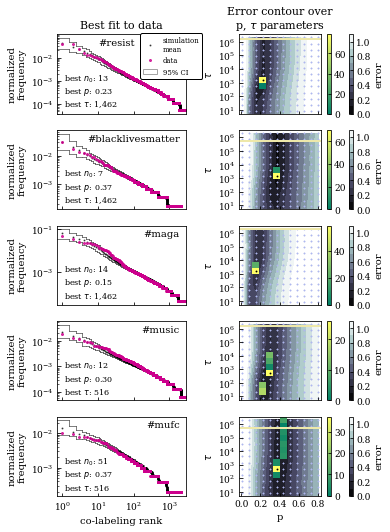

In [52]:
# Plot best simulation results.

_plot_primetags = anchorlabels

transientremoved = False

alpha = 0.05 # significance level

add_multisimhist = True
multisim_max = None

realmarkersize=4

fig, axs = pyp.subplots(figsize=(5.5, 7.5),
                        nrows=5, ncols=2)

for axi, primetag in enumerate(_plot_primetags):
    print(primetag)

    d_primetagsearchiter_simouts = d_primetag_paramlatticeouts[primetag]

    overallbestparams, bestparams_persearchiter, simul_counts_perrank, simul_probs_perrank = \
            d_primetag_bestparamsimulationouts[primetag]

    axpair = axs[axi, :]

    annot_topright = False
    cbarz = plot_meanrealFR_ptausearch_logtauscan_landscapeonly(axpair,
                                                               d_primetagsearchiter_simouts,
                                                               overallbestparams,
                                                               bestparams_persearchiter,
                                                               simul_probs_perrank,
                                                               add_multisimhist=add_multisimhist,
                                                               multisim_max = multisim_max,
                                                               annot_topright=annot_topright,
                                                               realmarker='.', realmarkersize=realmarkersize,
                                                               CIfill=False,
                                                               annot_primetag=None,
                                                               annot_fontsize=8,
                                                               annot_error=False,
                                                               CIstep=True,
                                                               CIsteplim=200,
                                                               rasterized=False)
    
    if axi == 0:
        axpair[0].annotate(primetag,
                            xy=(0.32, 0.95),
                            xycoords='axes fraction',
                            va='top',
                            ha='left')
    else:
        axpair[0].annotate(primetag,
                            xy=(0.95, 0.95),
                            xycoords='axes fraction',
                            va='top',
                            ha='right')

    if add_multisimhist:
        contourcbar, bestcbar = cbarz
    else:
        contourcbar = cbarz
        
        
    # Add the tau that would be 10x the empirical history length.
    tag_T = d_primetag_partialsimingreds[primetag]['T']
    xl = axpair[1].get_xlim()
    yl = axpair[1].get_ylim()
    axpair[1].plot(xl, [100*tag_T]*2, 'palegoldenrod', linewidth=2)
    axpair[1].set_xlim(xl)
    axpair[1].set_ylim(yl)
    
    axpair[0].set_ylabel('normalized\nfrequency')
    
    axpair[0].set_xlim(0.7, 3e3)
    axpair[0].set_xticks([1, 10, 100, 1000])
    
    for ax in axpair:
        ax.set_title('')
    
    if True:
        axpair[0].get_legend().remove()
    if axi == 0:
        
        magenta = np.array([206,0,142])/256.
        leglinehandles = [mpl.lines.Line2D([0], [0], marker='.', linewidth=0, color='k', markersize=2, alpha=0.6),
                          mpl.lines.Line2D([0], [0], marker='.', linewidth=0, markersize=realmarkersize, color=magenta, alpha=0.8),
                          mpl.patches.Rectangle(xy=(0., 0.), width=1., height=1.,
                                                facecolor='white',
                                                edgecolor=np.array([166]*3)/256.)]
        leglinelabs = ['simulation\nmean',
                       'data',
                       '95% CI']
        leg = axpair[0].legend(leglinehandles, leglinelabs,
                        loc='upper right',
                        bbox_to_anchor=[1.15, 1.06],
                        facecolor='white', framealpha=1, edgecolor='k',
                        fontsize='x-small')
    
    # Because the even tau-sampling is truncated to integer values,
    # there is some irregularity in the lattice for low tau.  This
    # cuts that off (and for the presented taus, doesn't interfere
    # with results).
    yl = axpair[1].get_ylim()
    axpair[1].set_ylim(5, yl[1])
    
    # Make sure there is more than one xtick on p log-scale axis.
    axpair[1].locator_params(axis='x', nbins=5)
    
for j in range(2):
    for ax in axs[:-1,j]:
        ax.set_xticklabels([])


axs[0,0].set_title('Best fit to data')
axs[0,1].set_title('Error contour over\n' + r'p, $\tau$' + ' parameters' )
axs[-1,0].set_xlabel('co-labeling rank')
axs[-1,1].set_xlabel('p')

fig.tight_layout(w_pad=0.005)